# POD with Gaussian Process Regression (GPR)
**Aim of this tutorial**: generate the POD modes from the snapshots for the Flow Over Cylinder problem using an accelerated version of the algorithm and create a reduced model using Gaussian Process Regression (GPR).

----
*To execute this notebook:* be sure to have the snapshots stored into *npz* format. 

The snapshots are related to the laminar Flow Over Cylinder in fluid dynamics, governed by the Navier-Stokes equations. In particular, the snapshots have been generated using the tutorial case reported [here](https://develop.openfoam.com/Development/openfoam/-/tree/OpenFOAM-v2012/tutorials/incompressible/pimpleFoam/laminar/cylinder2D).

In [1]:
import numpy as np

_data = np.load('Snapshots/of_dataset.npz', allow_pickle=True)

of_snaps = _data['snaps'].item()
times = _data['time_values']
is_vector = _data['is_vector']
var_names = _data['var_names']

print(var_names)

['U' 'p' 'vorticity']


Let us define some tex variables for visualisation

In [2]:
tex_var_names = [r'\mathbf{u}', 'p', r'\boldsymbol{\omega}']

The class `ReadFromOF` is able to generate a mesh for *dolfinx* from the OpenFOAM mesh, if the cells are either hexahedra or tetrahedra (no mixed cells). 

In [3]:
from pyforce.tools.write_read import ReadFromOF

of = ReadFromOF('OF_case/')
domain = of.create_mesh()

/Users/sriva/miniconda3/envs/ml/lib/python3.10/site-packages/ufl/__init__.py:244: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Hexahedron cells selected


Let us define the functional spaces and let us map the snapshots from OpenFOAM mesh to the *dolfinx* mesh.

In [159]:
from dolfinx.fem import FunctionSpace
import ufl

snaps = dict()

fun_spaces = list()
for field_i, field in enumerate(var_names):
    if is_vector[field_i]:
        fun_spaces.append(FunctionSpace(domain, ufl.VectorElement("CG", domain.ufl_cell(), 1)))
    else:
        fun_spaces.append(FunctionSpace(domain, ('Lagrange', 1)))
    
    snaps[field] = of.foam_to_dolfinx(fun_spaces[field_i], of_snaps[field], 
                                      verbose='Mapping field: ' + field)

Mapping field: U: 250.000 / 250.00 - 0.115 s/it
Mapping field: p: 250.000 / 250.00 - 0.041 s/it
Mapping field: vorticity: 250.000 / 250.00 - 0.117 s/it


Let us split the data into train and test

In [160]:
from pyforce.tools.functions_list import train_test_split

train_snaps = dict()
test_snaps  = dict()

for field in var_names:
    
    train_times, test_times, train_snaps[field], test_snaps[field] = train_test_split(times, snaps[field],
                                                                                      test_size=0.2,
                                                                                      random_state=42)

## Offline Phase: generation of the POD modes
We will use the `POD` class to generate the POD modes from the snapshots. The `POD` class is able to compute the POD modes using an accelerated version of the algorithm, exploiting the randomized SVD.

At first, the correlation matrix is computed and its eigenvalues and eigenvectors are calculated.

In [161]:
from pyforce.offline.pod import POD as PODOffline

pod_offline = {
    field: PODOffline(train_snap=train_snaps[field], name=field, 
                      svd_acceleration_rank=40, verbose=True)
    for field in var_names }

Computing U correlation matrix: 40.000 / 40.00 - 0.266 s/it
Computing p correlation matrix: 40.000 / 40.00 - 0.159 s/it
Computing vorticity correlation matrix: 40.000 / 40.00 - 0.269 s/it


Let us plot the eigenvalues

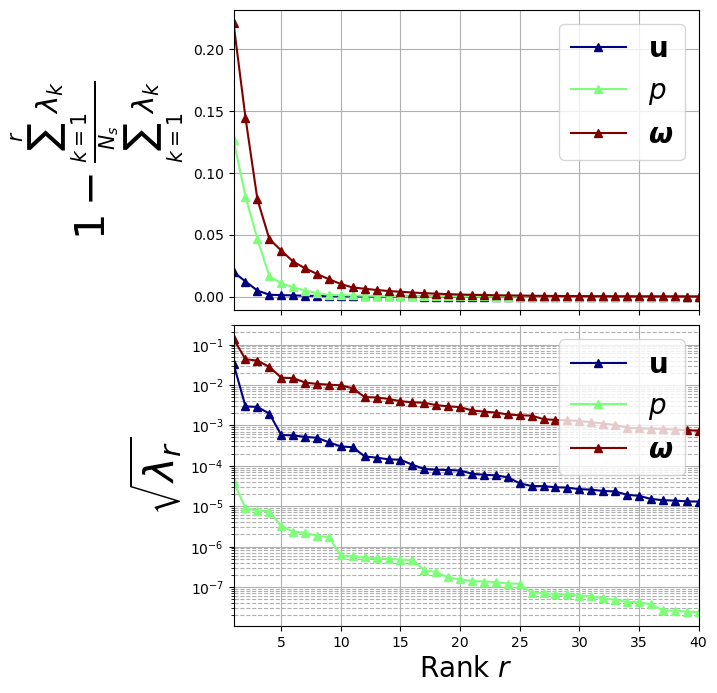

In [162]:
import matplotlib.pyplot as plt
from matplotlib import cm

fig, axs = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

color = iter(cm.jet(np.linspace(0, 1, len(var_names))))

# Plot on the first subplot
for field_i, field in enumerate(var_names):
    c = next(color)
    axs[0].plot(
        np.arange(1, pod_offline[field].eigenvalues.size + 1, 1),
        1 - np.cumsum(pod_offline[field].eigenvalues) / sum(pod_offline[field].eigenvalues),
        "-^", c=c, label="$" + tex_var_names[field_i] + "$", linewidth=1.5
    )
    
    axs[1].semilogy(
        np.arange(1, pod_offline[field].eigenvalues[:40].size + 1, 1),
        np.sqrt(pod_offline[field].eigenvalues[:40]),
        "-^", c=c, label="$" + tex_var_names[field_i] + "$", linewidth=1.5
    )

axs[0].set_ylabel(r"$1- \frac{\sum_{k=1}^{r}\lambda_k}{\sum_{k=1}^{N_s} \lambda_k}$", fontsize=30)
axs[1].set_ylabel(r"$\sqrt{\lambda_r}$", fontsize=30)

for ax in axs:
    ax.set_xticks(np.arange(0, 40 + 1, 5))
    ax.set_xlim(1, 40)
    ax.grid(which='major', linestyle='-')
    ax.grid(which='minor', linestyle='--')
    ax.legend(fontsize=20)

axs[1].set_xlabel(r"Rank $r$", fontsize=20)
    
fig.subplots_adjust(hspace=0.05)

Let us compute the POD modes and the POD coefficients.

In [163]:
from pyforce.tools.backends import LoopProgress

Nmodes = [10,10,10]

train_pod_coeffs = dict()
test_pod_coeffs  = dict()

for field_i, field in enumerate(var_names):

    pod_offline[field].compute_basis(train_snaps[field], maxBasis=Nmodes[field_i])

    bar = LoopProgress(msg = f"Computing Train POD coefficients for {field}",
                       final = len(train_snaps[field]))
    train_pod_coeffs[field] = np.zeros((len(train_snaps[field]), Nmodes[field_i]))
    for tt in range(len(train_snaps[field])):
        train_pod_coeffs[field][tt] = pod_offline[field].projection(train_snaps[field](tt), 
                                                                    N=Nmodes[field_i])
        bar.update(1)

    del bar

    bar = LoopProgress(msg = f"Computing Test  POD coefficients for {field}",
                       final = len(test_snaps[field]))
    test_pod_coeffs[field] = np.zeros((len(test_snaps[field]), Nmodes[field_i]))
    for tt in range(len(test_snaps[field])):
        test_pod_coeffs[field][tt] = pod_offline[field].projection(test_snaps[field](tt), 
                                                            N=Nmodes[field_i])
        bar.update(1)

    del bar

Computing Train POD coefficients for U: 200.000 / 200.00 - 0.113 s/it
Computing Test  POD coefficients for U: 50.000 / 50.00 - 0.114 s/it
Computing Train POD coefficients for p: 200.000 / 200.00 - 0.075 s/it
Computing Test  POD coefficients for p: 50.000 / 50.00 - 0.075 s/it
Computing Train POD coefficients for vorticity: 200.000 / 200.00 - 0.114 s/it
Computing Test  POD coefficients for vorticity: 50.000 / 50.00 - 0.112 s/it


## Training Phase: Gaussian Process Regression (GPR)
Using the `GaussianProcessRergression` class from `sklearn`, we can train a GPR model on the POD coefficients. The GPR model will be used to reconstruct the POD coefficients: the input is represented by some pressure measurements, and the output is the POD coefficients.

In [164]:
np.random.seed(42)
idx_sens_locs = np.random.choice(np.arange(train_snaps['p'].fun_shape), 5, replace=False)

train_measures = train_snaps['p'].return_matrix()[idx_sens_locs]
test_measures  = test_snaps['p'].return_matrix()[idx_sens_locs]

# plt.plot(train_times, train_measures.T, 'o', label='Train measures')

from sklearn.preprocessing import MinMaxScaler, StandardScaler
input_scaler = MinMaxScaler()
input_scaler.fit(train_measures.T)

stacked_train_coeffs = np.hstack([
    train_pod_coeffs[field] for field in var_names
])
stacked_test_coeffs = np.hstack([
    test_pod_coeffs[field] for field in var_names
])

output_scaler = StandardScaler()
output_scaler.fit(stacked_train_coeffs)

StandardScaler()

Let us train the GPR model on the POD coefficients: a multiple-input multiple-output (MIMO) model is trained, where the inputs are the pressure measurements and the outputs are the POD coefficients.

In [165]:
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

# Define the kernel for the Gaussian Process
kernels = dict()
for rr in range(sum(Nmodes)):
    kernels[rr] = 1.0 * RBF(length_scale=1, length_scale_bounds=(1e-6, 1e2)) + WhiteKernel(
        noise_level=1, noise_level_bounds=(1e-6, 1e2)
    )

from sklearn.gaussian_process import GaussianProcessRegressor

# Train the GPR models
gpr_models = GaussianProcessRegressor(
        kernel=kernels[rr], n_restarts_optimizer=10, alpha=1e-6, normalize_y=False
    )
gpr_models.fit(input_scaler.transform(train_measures.T), 
                    output_scaler.transform(stacked_train_coeffs))

GaussianProcessRegressor(alpha=1e-06,
                         kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10)

## Test/Online Phase: reconstruction of the POD coefficients
We can now use the trained GPR model to reconstruct the POD coefficients from the pressure measurements.

In [166]:
new_t = np.linspace(min(times), max(times), 1000)

sorting_train_idx = np.argsort(train_times)

new_measures = np.zeros((len(idx_sens_locs), len(new_t)))
for mm in range(len(train_measures)):
    new_measures[mm] = np.interp(new_t, train_times[sorting_train_idx], train_measures[mm, sorting_train_idx])

predicted_gpr_coeffs, gpr_std = gpr_models.predict(input_scaler.transform(new_measures.T), return_std=True)

predicted_gpr_coeffs = output_scaler.inverse_transform(predicted_gpr_coeffs)
gpr_std = output_scaler.inverse_transform(gpr_std) - output_scaler.mean_[None,:]

Let us make a plot for each field

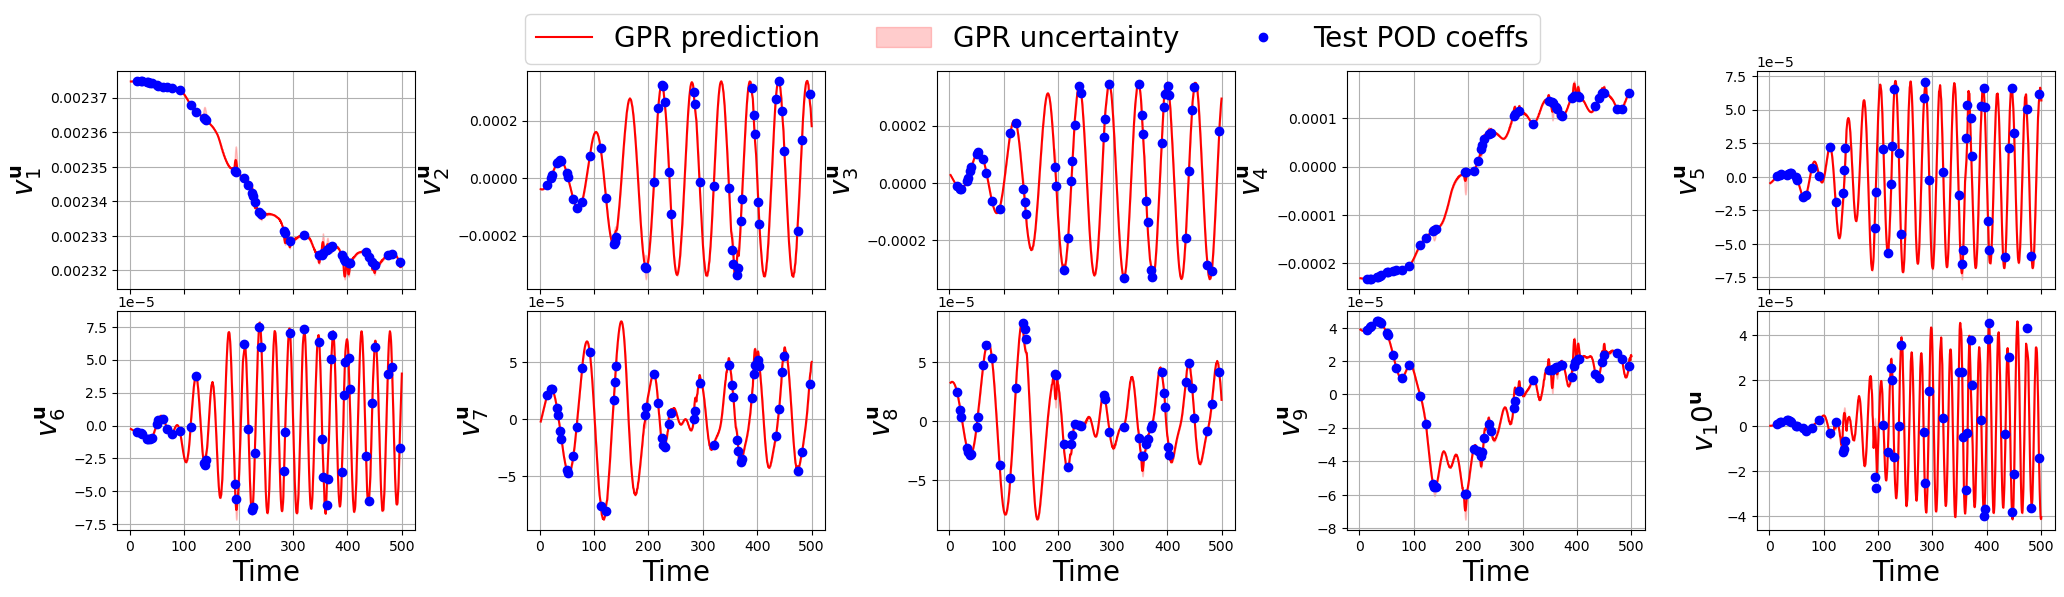

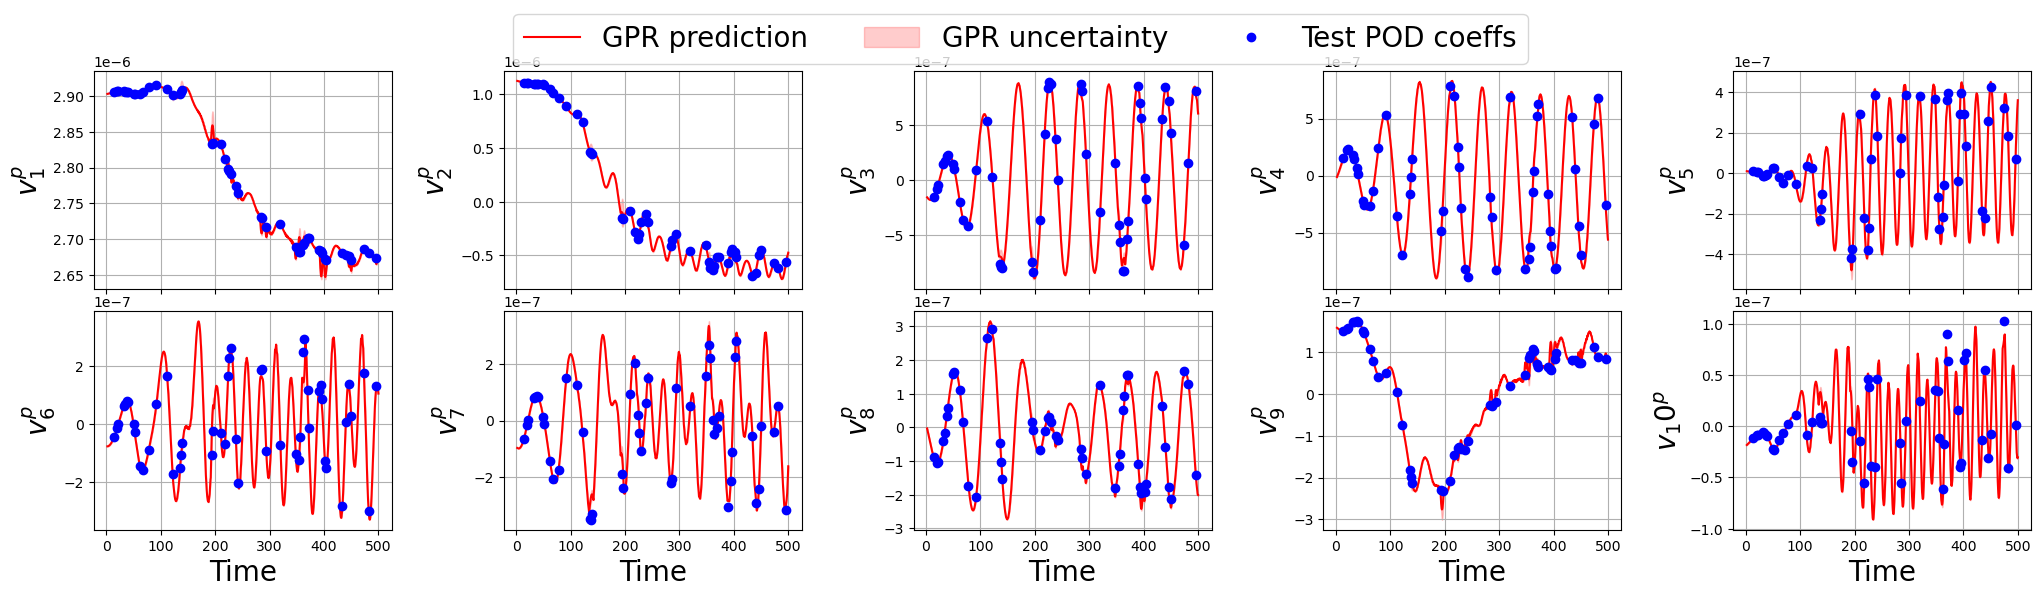

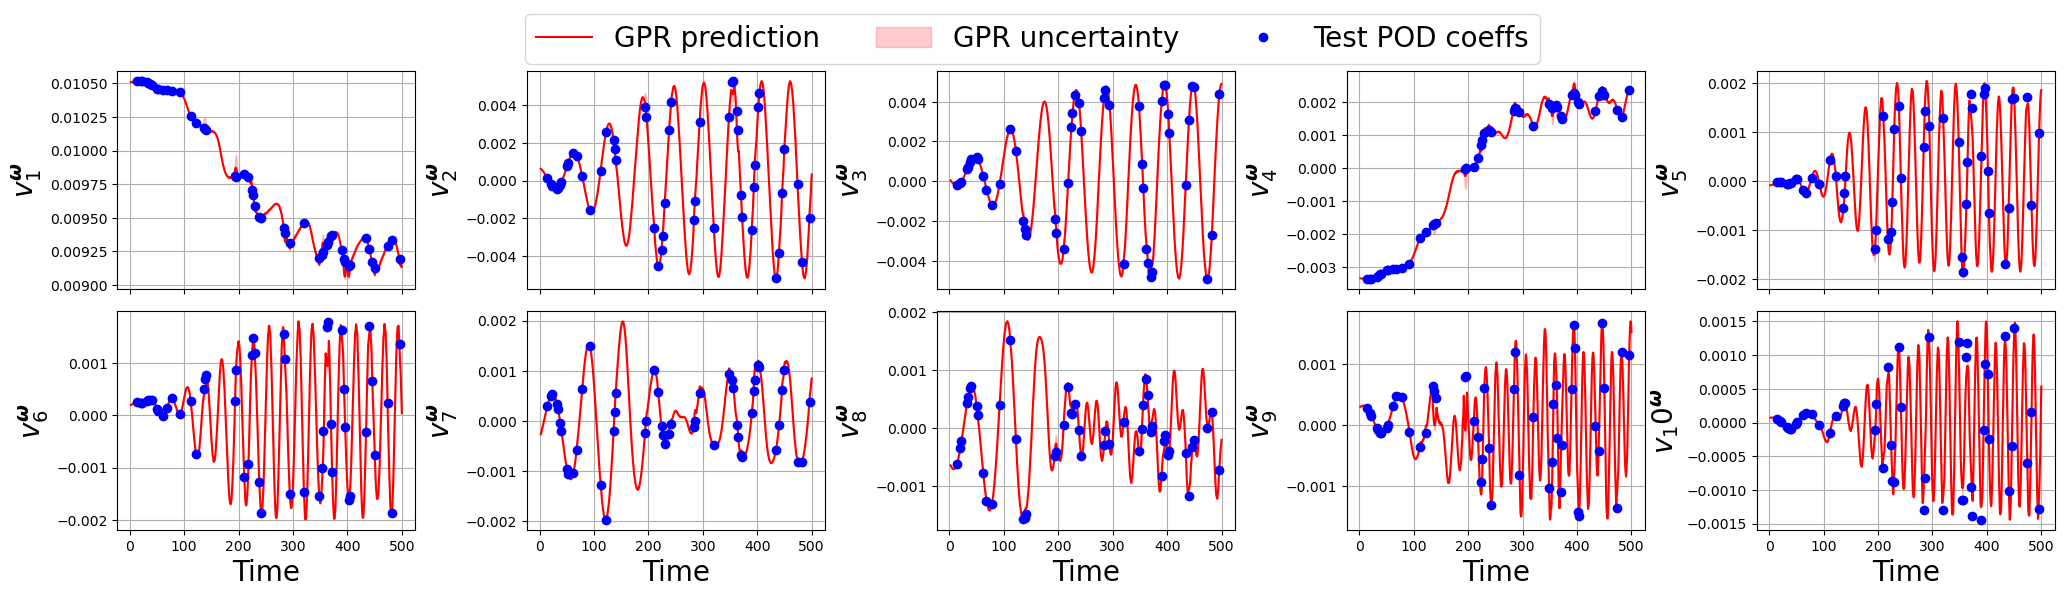

In [167]:
for field_i, field in enumerate(var_names):
    nrows = 2
    ncols = 5
    fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 3 * nrows), sharex=True)
    axs = axs.flatten()

    for rr in range(nrows * ncols):
        axs[rr].plot(new_t, predicted_gpr_coeffs[:, rr+sum(Nmodes[:field_i])], label='GPR prediction', color='r')
        axs[rr].fill_between(new_t,
                            predicted_gpr_coeffs[:, rr+sum(Nmodes[:field_i])] - gpr_std[:, rr+sum(Nmodes[:field_i])],
                            predicted_gpr_coeffs[:, rr+sum(Nmodes[:field_i])] + gpr_std[:, rr+sum(Nmodes[:field_i])],
                            alpha=0.2, color='r', label='GPR uncertainty')
        
        axs[rr].plot(test_times, test_pod_coeffs[field][:, rr], 'o', label='Test POD coeffs', color='b')
        axs[rr].set_ylabel(r'$v_'+str(rr+1)+'^{'+tex_var_names[field_i]+'}$', fontsize=20)

        if rr >= ncols:
            axs[rr].set_xlabel('Time', fontsize=20)

        axs[rr].grid()

    _line, _labels = axs[0].get_legend_handles_labels()
    fig.legend(_line, _labels, loc='upper center', fontsize=20, ncols=3)
    fig.subplots_adjust(top=0.875, wspace=0.375, hspace=0.1)
    plt.show()

Let us make some contour plots using `matplotlib` to visualize the reconstructed fields and show a different way of plotting

In [ ]:
.shape

(70396, 50)

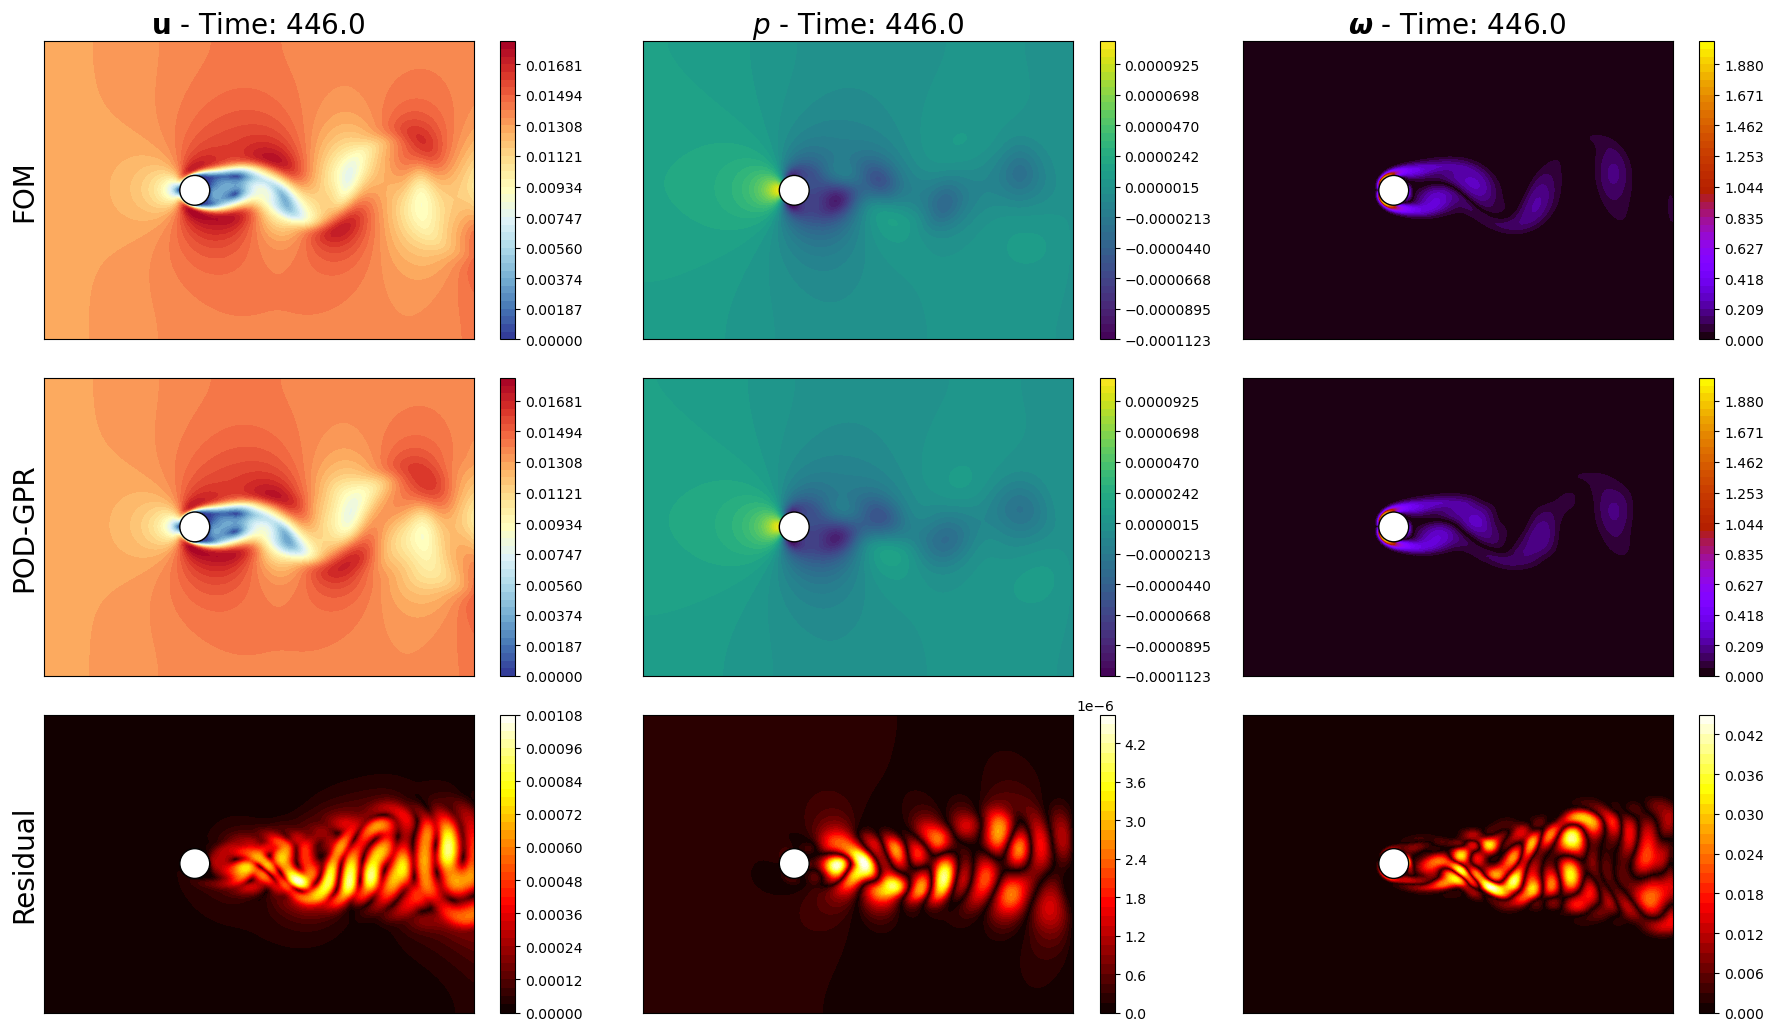

In [198]:
from matplotlib import patches
from IPython.display import clear_output as clc

def get_mag(u_vec):
    """
    Function to get the magnitude of a vector field in FEniCSx format (data are assumed 2D).
    """
    u = u_vec[0::3]
    v = u_vec[1::3]
    w = u_vec[2::3]
    return np.sqrt(u**2 + v**2 + w**2)

class PlotFlowCyl():
    
    def __init__(self, domain, centre = (0., 0.0), radius = 0.06):
        self.domain = domain

        width = np.max(domain[:,0]) - np.min(domain[:,0])
        height = np.max(domain[:,1]) - np.min(domain[:,1])

        self.aspect = height / width

        self.centre = centre
        self.radius = radius
    
    def create_circle(self, ls=1):
        
        circle = patches.Circle(self.centre, self.radius, edgecolor='black', facecolor='white', linewidth=ls)
        return circle
    
    def plot_contour(self, ax, snap, cmap = cm.RdYlBu_r, levels=40, show_ticks=False):

        if snap.shape[0] == 3*self.domain.shape[0]:
            snap = get_mag(snap)
            
        plot = ax.tricontourf(self.domain[:,0], self.domain[:,1], snap, cmap=cmap, levels=levels)
        ax.add_patch(self.create_circle())
        
        if not show_ticks:
            ax.set_xticks([])
            ax.set_yticks([])

        return plot
    
plotter = PlotFlowCyl(domain=domain.geometry.x)

cmaps = [cm.RdYlBu_r, cm.viridis, cm.gnuplot]

sorting_test_idx = np.argsort(test_times)

sampling = 5
for ll in range(sampling, len(test_times), sampling):
    tt = sorting_test_idx[ll]

    predicted_gpr_coeffs = gpr_models.predict(input_scaler.transform(test_measures.T), return_std=False)
    predicted_gpr_coeffs = output_scaler.inverse_transform(predicted_gpr_coeffs)[tt]

    nrows = 3
    ncols = len(var_names)
    fig, axs = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows * plotter.aspect))

    for field_i, field in enumerate(var_names):

        levels = np.linspace(np.min(get_mag(test_snaps[field].return_matrix())), 
                            np.max(get_mag(test_snaps[field].return_matrix())), 40) if is_vector[field_i] else np.linspace(np.min(test_snaps[field].return_matrix()), 
                                                                                                                            np.max(test_snaps[field].return_matrix()), 40)
        

        pod_recon = pod_offline[field].PODmodes.lin_combine(predicted_gpr_coeffs[sum(Nmodes[:field_i]):sum(Nmodes[:field_i+1])])
        
        cont = plotter.plot_contour(axs[0, field_i], test_snaps[field](tt), cmap=cmaps[field_i], levels=levels, show_ticks=False)
        plotter.plot_contour(axs[1, field_i], pod_recon, cmap=cmaps[field_i], levels=levels, show_ticks=False)

        residual = np.abs(test_snaps[field](tt) - pod_recon)
        res_cont = plotter.plot_contour(axs[2, field_i], residual, cmap=cm.hot, levels=40, show_ticks=False)

        fig.colorbar(cont, ax=axs[0, field_i], orientation='vertical', pad=0.05)
        fig.colorbar(cont, ax=axs[1, field_i], orientation='vertical', pad=0.05)
        fig.colorbar(res_cont, ax=axs[2, field_i], orientation='vertical', pad=0.05)

        axs[0, field_i].set_title(r'$' + tex_var_names[field_i] + r'$ - Time: ' + str(round(test_times[tt], 2)), fontsize=20)
        
    axs[0,0].set_ylabel('FOM', fontsize=20)
    axs[1,0].set_ylabel('POD-GPR', fontsize=20)
    axs[2,0].set_ylabel('Residual', fontsize=20)

    plt.tight_layout()

    plt.show()
    clc(wait=True)
    plt.close(fig)